In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import load_config

In [7]:
config = load_config("../configs/config.yaml")

### Read and look into files

In [8]:
data_mat = pd.read_csv(config['paths']['data_mat_path'])
data_mat.head(5)

,sample,FT-000,FT-001,FT-002,FT-003,FT-004,FT-005,FT-006,FT-007,FT-008,...,FT-242,FT-243,FT-244,FT-245,FT-246,FT-247,FT-248,FT-249,FT-250,FT-251
0,20241106-297-Blank1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,20241106-297-Blank2,0.0,0.000000,0.0,5.770641,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.534493,0.0,0.0,0.0
2,20241106-297-Blank3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.469501,0.0,0.0,0.0
3,20241106-297-Blank4,0.0,5.497865,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,20241106-297-Blank5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [9]:
feat_meta = pd.read_csv(config['paths']['feat_meta_path'])
feat_meta.head(5)

,feature,mz,mz max,mz min,mz std,rt,rt end,rt max,rt min,rt start,rt std
0,FT-000,359.108768,359.130591,359.090122,0.010955,543.846374,561.270879,546.697803,539.941156,528.714227,1.683901
1,FT-001,357.109546,357.130018,357.091871,0.010668,543.839157,563.021530,546.948017,540.038924,528.530311,1.662290
2,FT-002,889.649931,889.702216,889.601547,0.025552,609.099742,627.717251,611.746501,606.426553,596.789046,1.324647
3,FT-003,355.111928,355.132772,355.093653,0.010508,543.995269,566.951285,547.164503,540.681882,526.943213,1.609071
4,FT-004,888.645365,888.696941,888.600202,0.026161,609.255652,632.996442,612.008732,606.778809,595.461688,1.254684


In [10]:
sample_meta = pd.read_csv(config['paths']['sample_meta_path'])
sample_meta.head(5)

,sample,class,id,order,batch
0,20241106-297-Blank1,B,20241106-297-Blank1,1,1
1,20241106-297-Blank2,B,20241106-297-Blank2,2,1
2,20241106-297-Blank3,B,20241106-297-Blank3,3,1
3,20241106-297-Blank4,B,20241106-297-Blank4,102,1
4,20241106-297-Blank5,B,20241106-297-Blank5,103,1


In [11]:
exog_stand = pd.read_csv(config['paths']['exog_stan_path'])
exog_stand

,compound_id,mz,Retention_time
0,GU4,886.40,610
1,GU5,1048.45,753
2,GU14,1253.96,1500
3,GU15,1334.99,1551


### 1. How many features have been detected, how is the distribution across mz and retention time, and across classes?

In [6]:
print(f'Number of features: {data_mat.shape[1]-1}')
print(f'Number of samples: {data_mat.shape[0]}')

Number of features: 252
Number of samples: 124


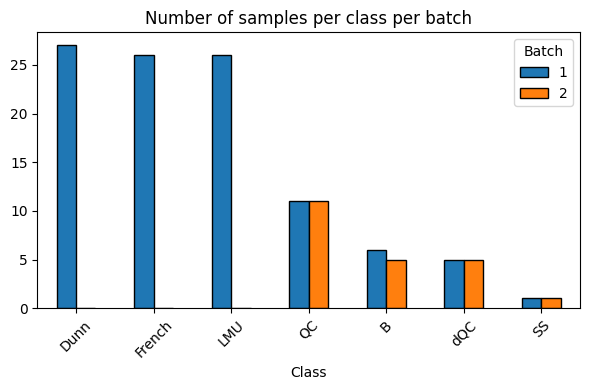

In [7]:
# Group and pivot the data
class_batch_counts = sample_meta.groupby(['class', 'batch']).size().unstack(fill_value=0)

# Sort by total count across batches
class_batch_counts['Total'] = class_batch_counts.sum(axis=1)
class_batch_counts = class_batch_counts.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plot grouped bar plot
class_batch_counts.plot(kind='bar', figsize=(6, 4), edgecolor='black')
plt.title('Number of samples per class per batch')
plt.xlabel('Class')
plt.legend(title='Batch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


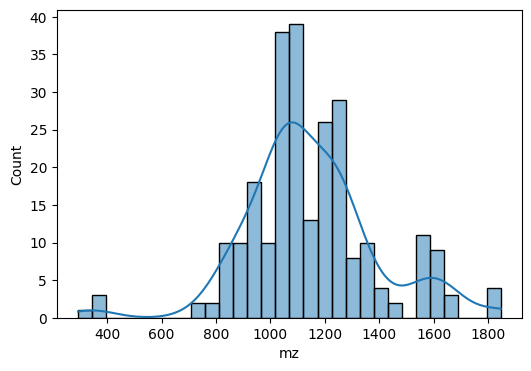

In [8]:
# mz distribution
plt.figure(figsize=(6, 4))
sns.histplot(feat_meta['mz'], kde=True, bins=30)
plt.xlabel('mz')
plt.show()

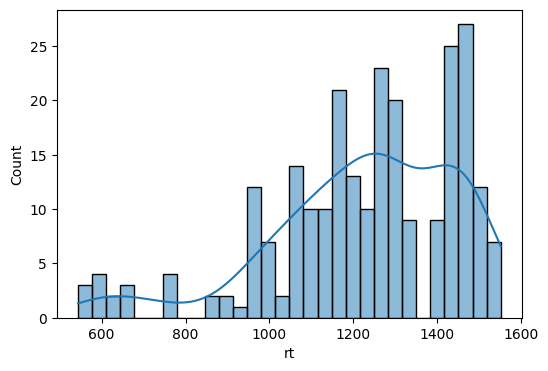

In [ ]:
# rt distribution
plt.figure(figsize=(6, 4))
sns.histplot(feat_meta['rt'], kde=True, bins=30)
plt.xlabel('rt')
plt.show()

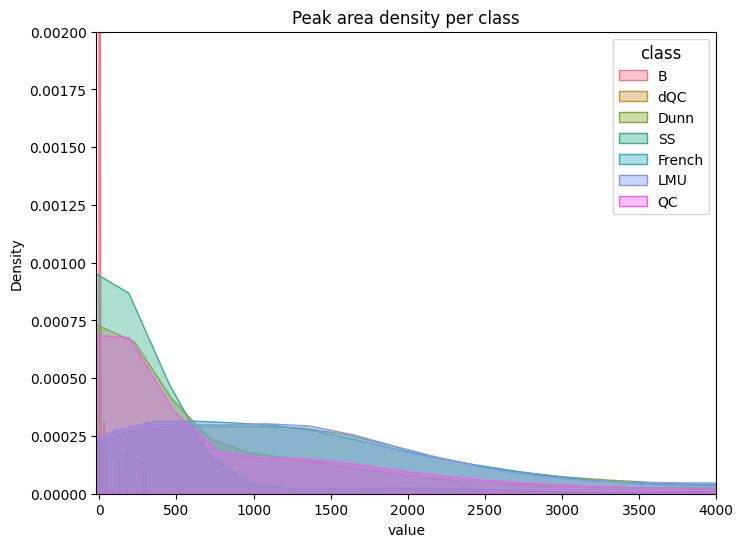

In [18]:
# Peak area density per class
data_mat_with_class = data_mat.merge(sample_meta[['sample', 'class']], how='left')

# Melt numeric features into long 
numeric_features = data_mat_with_class.select_dtypes(include='number')
melted_df = numeric_features.copy()
melted_df['class'] = data_mat_with_class['class']
melted_df = melted_df.melt(id_vars='class', var_name='feature', value_name='value')


# Color palette
palette = sns.color_palette('husl', len(melted_df['class'].unique()))

# Overley plots
plt.figure(figsize=(8, 6))

for color, category in zip(palette, melted_df['class'].unique()):
    subset = melted_df[melted_df['class'] == category]
    sns.kdeplot(
        data=subset,
        x='value',
        label=str(category), 
        fill=True,
        alpha=0.4,
        bw_adjust=0.4,
        color=color
    )


plt.ylim(0, 0.002)
plt.xlim(-20, 4000)
plt.title('Peak area density per class')
plt.legend(title='class', loc='upper right', fontsize='medium', title_fontsize='large')
plt.show()

### 2. How is the contamination in the experiment?

In [123]:
# extract Blank samples
data_mat_blank = data_mat.merge(sample_meta[['sample', 'class', 'batch']], how='left')
data_mat_blank = data_mat_blank[data_mat_blank['class'] == 'B']
ft_columns = [col for col in data_mat_blank.columns if col.startswith('FT')]

# separate batches
data_mat_blank_batch1 = data_mat_blank[(data_mat_blank['class'] == 'B') & ((data_mat_blank['batch'] == 1))]
data_mat_blank_batch2 = data_mat_blank[(data_mat_blank['class'] == 'B') & ((data_mat_blank['batch'] == 2))]


data_mat_blank_batch1.shape, data_mat_blank_batch2.shape

((6, 255), (5, 255))

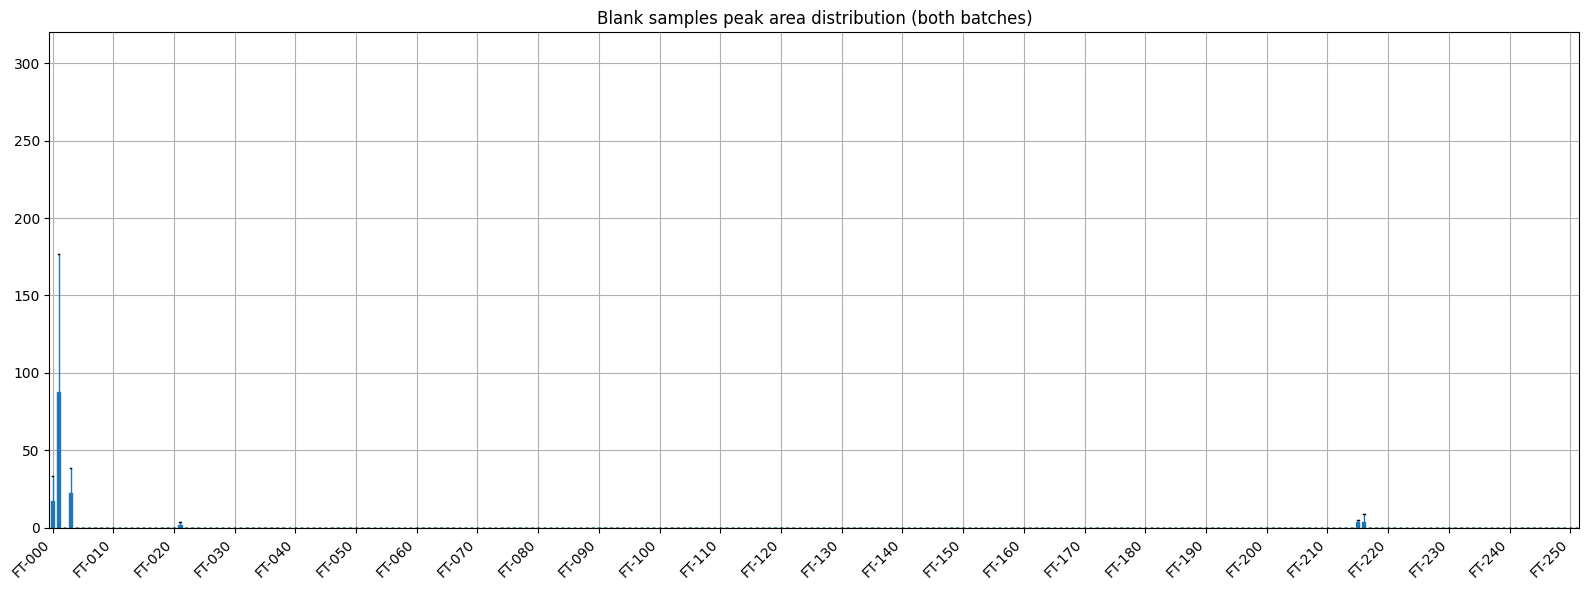

In [135]:
fig, ax = plt.subplots(figsize=(16, 6))  

# Boxplot for all features
data_mat_blank[ft_columns].boxplot(ax=ax, vert=True, patch_artist=True, showfliers=False)

ax.set_xticks(range(1, 253, 10))
ax.set_xticklabels([f"FT-{i:03}" for i in range(0, 252, 10)], rotation=45, ha='right')
ax.set_title('Blank samples peak area distribution (both batches)')
plt.ylim(0, 320)
plt.tight_layout()
plt.show()

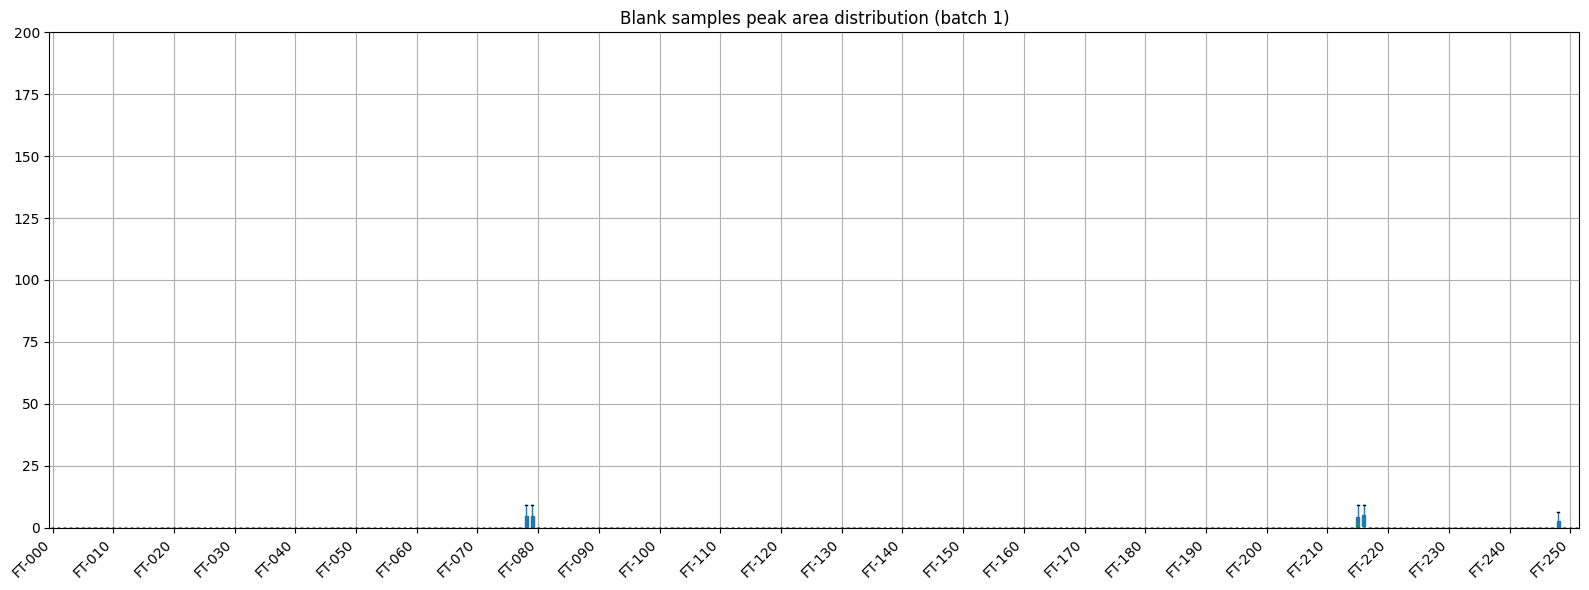

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))  

# Boxplot for all features
data_mat_blank_batch1[ft_columns].boxplot(ax=ax, vert=True, patch_artist=True, showfliers=False)

ax.set_xticks(range(1, 253, 10))
ax.set_xticklabels([f"FT-{i:03}" for i in range(0, 252, 10)], rotation=45, ha='right')
ax.set_title('Blank samples peak area distribution (batch 1)')
plt.ylim(0, 320)
plt.tight_layout()
plt.show()

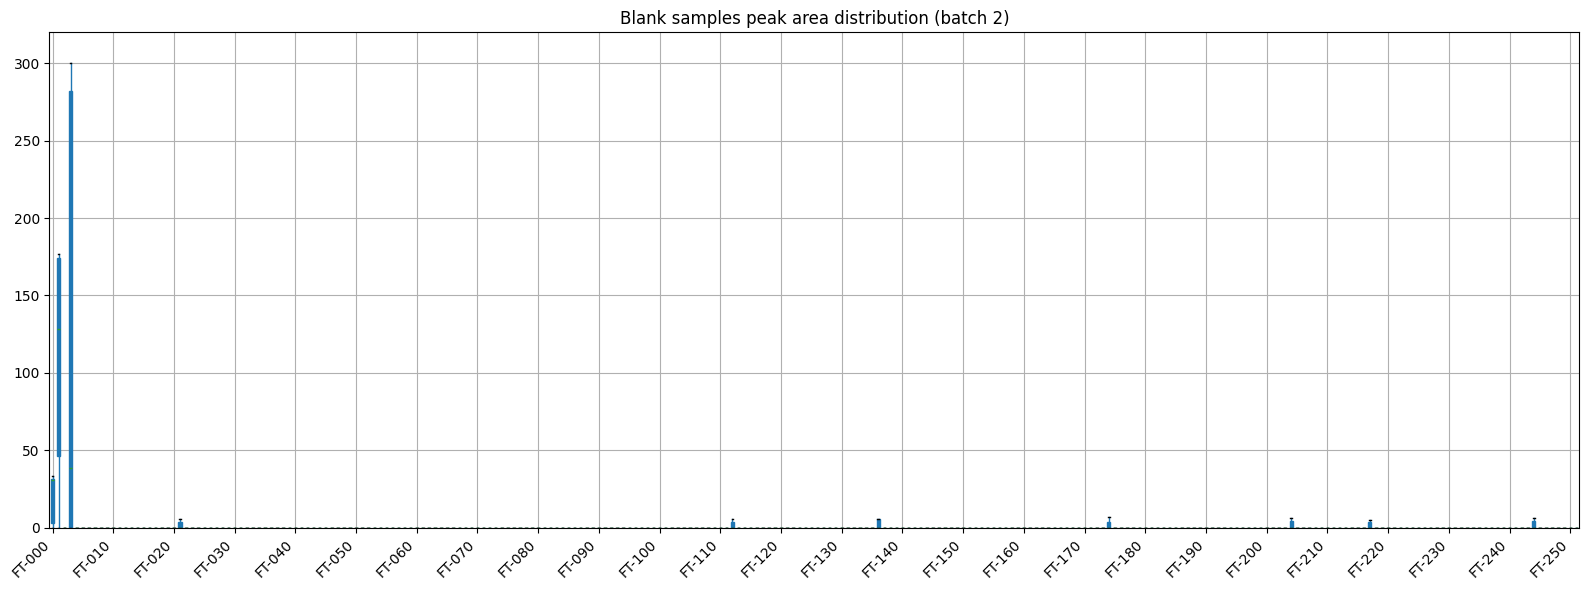

In [134]:
fig, ax = plt.subplots(figsize=(16, 6))  

# Boxplot for all features
data_mat_blank_batch2[ft_columns].boxplot(ax=ax, vert=True, patch_artist=True, showfliers=False)

ax.set_xticks(range(1, 253, 10))
ax.set_xticklabels([f"FT-{i:03}" for i in range(0, 252, 10)], rotation=45, ha='right')
ax.set_title('Blank samples peak area distribution (batch 2)')
plt.ylim(0, 320)
plt.tight_layout()
plt.show()

### 3. Are the standards detected consistently across the experiment?

### 4. How is the distribution of intensities across the classes? Are there any trends with respect to classes, batches, run order?

### 5. What differences are there between sample classes and/or QCs? Is it consistent across batches?